In [1]:
# Data reading, transforming ibraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Text processing libraries 
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# Model selection an training libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Library for scoring and accuracy of model
from sklearn.metrics import accuracy_score

'''
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
'''

'\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, but they won\'t be saved outside of the current session\n'

### Reading data

In [2]:
import zipfile

train_zip_file_path = "/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip"
test_zip_file_path = "/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip"
paths = [train_zip_file_path, test_zip_file_path]
extract_path = "/kaggle/working/"

# Extract if the file exists
for path in paths:
    if os.path.exists(path):
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
            print("Extraction complete!")
    else:
        print("Error: File not found.")

Extraction complete!
Extraction complete!


In [3]:
# Setting file path to read tsv file
training_set_file_path = "/kaggle/working/train.tsv"  # Update this path if necessary


try:
    movie_data = pd.read_csv(training_set_file_path, sep="\t", on_bad_lines="skip", engine="python")
    print("Reading successful")  # Display the first few rows
except Exception as e:
    print("Error:", e)


Reading successful


### Knowing dataset | Data analysis

In [4]:
# Checking the first five rows
movie_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
# Shape of dataset
print(f"Number of rows: {movie_data.shape[0]}")
print(f"Number of columns: {movie_data.shape[1]}")

Number of rows: 156060
Number of columns: 4


In [6]:
# Columns
movie_data.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [7]:
# Null values
movie_data.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [8]:
# Unique values and count of unique values
print("Number of unique data per column")
print(movie_data.nunique())

Number of unique data per column
PhraseId      156060
SentenceId      8529
Phrase        156060
Sentiment          5
dtype: int64


In [9]:
# Count of data per unique value in sentiment column
print(movie_data['Sentiment'].value_counts())

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64


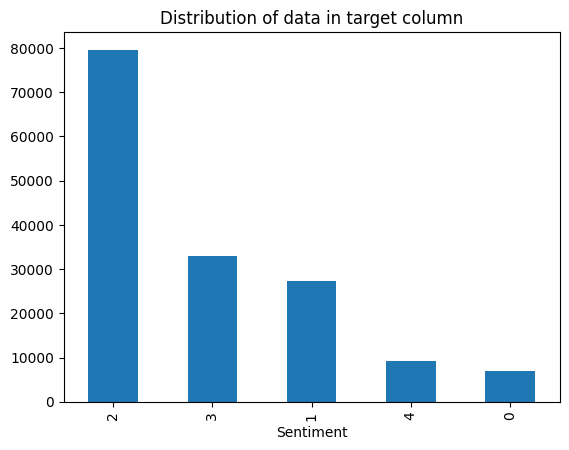

In [10]:
# Plotting the count of data per unique value in sentiment column
plt.title("Distribution of data in target column")
plt.legend
movie_data['Sentiment'].value_counts().plot(kind='bar')
plt.show()

### Splitting data into independent and dependent variables

In [11]:
X = movie_data['Phrase']
y = movie_data['Sentiment']

### Text pre-processing

In [12]:
# Creating a function for text pre-processing
def text_processor(arr):
    arr = arr.apply(lambda x:re.sub('[^a-zA-Z]', ' ', x)) # Removing punctuations
    arr = arr.apply(lambda x:x.lower())                   # Converting to lower case
    arr = arr.apply(lambda x:word_tokenize(x))            # Tokenizing
    arr = arr.apply(lambda x:[word for word in x if word not in stopwords.words('english')]) # Removing stopwords
    arr = arr.apply(lambda x:[stemmer.stem(word) for word in x])   # Stemming
    arr = arr.apply(lambda x:" ".join(x))                 # Joining words
    return arr                                            # Returning processed text column

In [13]:
# Processing input text column with text processor function
X = text_processor(X)

In [14]:
# Vectorizing
X = vectorizer.fit_transform(X.values)

### Train-test-split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(124848, 10488)
(124848,)
(31212, 10488)
(31212,)


### Model creation, training & scoring

In [16]:
# Model creation & training
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Prediction
nb_pred = nb_model.predict(X_test)

# Accuracy
nb_score = accuracy_score(nb_pred, y_test)
print(f"Naive bayes model's score is {nb_score}")

Naive bayes model's score is 0.6090606177111367


# Predicting Validation set

In [17]:
# Reading test set
testing_set_file_path = "/kaggle/working/test.tsv"
submit_set = pd.read_csv(testing_set_file_path, sep="\t", on_bad_lines="skip", engine="python")
submit_set.isna().sum()

PhraseId      0
SentenceId    0
Phrase        1
dtype: int64

In [18]:
# Checking null value
submit_set[submit_set['Phrase'].isna()]

,PhraseId,SentenceId,Phrase
15519,171580,9213,NaN


In [19]:
# Makig a constant with a sentence of same 'SentenceId'
imputing_constant = submit_set[submit_set['SentenceId']== 9213]['Phrase'].values[0]

# Imputing null value
submit_set = submit_set.fillna(imputing_constant)

In [20]:
# Pre-processing test set
submit_X = submit_set['Phrase']
submit_X = text_processor(submit_X)
submit_X = vectorizer.transform(submit_X.values)
submit_pred = nb_model.predict(submit_X)
submit_set['Sentiment'] = submit_pred
submission = submit_set[['PhraseId', 'Sentiment']]

In [21]:
# How submission file looks
submission

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2


In [22]:
submission.to_csv("submission_file.csv", index=False)